# <center>CAPSTONE PROJECT : BENGALURU RESTAURANT ANALYSIS

## Introduction

  Bengaluru a.k.a Bangalore, a city in the Karnataka state in India, is the face of country's IT Industry. The IT industry employs a large number of people from across different geographies. A lot of people from other states/nations works and lives in Bengaluru. Obviously, there are the restaurants too in Bengaluru serving a wide variety of cuisines from diffrent parts of the world. This makes Bengaluru a perfect candidate for a data science projet analysing its neighborhoods and food habits. This notebook makes an analysis of Bengaluru neighborhoods based on its restaurants and other venues. It will be helpful for someone trying to open a restaurant in Bengaluru or someone just wanting to know what is popular where in Bengaluru!!

   The dataset for this analysis is taken from <b>kaggle</b> (<a href="https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants"> Bengaluru Restaurant Data by Himanshu Poddar</a>). The geographical coordinates of the neighborhoods are obtained using <b>GeoPy</b> library package. <b>Foursquare</b> neighborhood service provider's API is to be leveraged to get the trending venues in the neighborhoods.
   
   

## Data Aquisition :

#### Let's import the Necessary Libraries:

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
%matplotlib inline

#### Now we'll load the data into pandas data frame

Initially pandas was not able to read the original 547 MB CSV dataset because of the hardware incapacity of my PC. I had used an ETL tool, pentaho kettle, to read the .csv file and reduce the size by removing some fields which are not much relevant to our analysis such as url, address and reviews list.

In [138]:
#df = pd.read_csv('zomato.csv',nrows=30000)
df = pd.read_csv('file3.csv')
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),menu_item,listed_in(type),listed_in(city),Unnamed: 13
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,[],Buffet,Banashankari,NaN
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,[],Buffet,Banashankari,NaN
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,[],Buffet,Banashankari,NaN
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,[],Buffet,Banashankari,NaN
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,[],Buffet,Banashankari,NaN


In [139]:
df.shape

(51717, 14)

In [140]:
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines', 'approx_cost(for two people)',
       'menu_item', 'listed_in(type)', 'listed_in(city)', 'Unnamed: 13'],
      dtype='object')

### Description of the data columns

* **name** - contains the name of the restaurant
* **online_order** - whether online ordering is available in the restaurant or not
* **book_table** - table book option available or not
* **rate** - contains the overall rating of the restaurant out of 5
* **votes** - contains total number of rating for the restaurant as of the above mentioned date
* **phone** - contains the phone number of the restaurant
* **location** - contains the neighborhood in which the restaurant is located
* **rest_type** - restaurant category (like quickbites, bakery etc.)
* **dish_liked** - dishes people liked in the restaurant
* **cuisines** - food styles, separated by comma
* **approx_cost(for two people)** - contains the approximate cost for meal for two people
* **menu_item** - contains list of menus available in the restaurant
* **listed_in(type)** - restaurant categories in which the restaurant is listed
* **listed_in(city)** - contains the neighborhood in which the restaurant is listed

In [141]:
df.dtypes

name                            object
online_order                    object
book_table                      object
rate                            object
votes                            int64
location                        object
rest_type                       object
dish_liked                      object
cuisines                        object
approx_cost(for two people)    float64
menu_item                       object
listed_in(type)                 object
listed_in(city)                 object
Unnamed: 13                     object
dtype: object

## Data Cleaning :

#### First let us remove the duplicate values if there is any

In [142]:
df.drop_duplicates(inplace=True)
df.shape

(51630, 14)

#### Let us check which fields has null values and decide whether to keep them or not

In [143]:
pd.DataFrame({'Column':[i.upper() for i in df.columns],
                      'Null count':df.isnull().sum().values,
                      'Null %':((df.isnull().sum().values/len(df))*100).round(2)
                     })

,Column,Null count,Null %
0,NAME,0,0.00
1,ONLINE_ORDER,0,0.00
2,BOOK_TABLE,0,0.00
3,RATE,7759,15.03
4,VOTES,0,0.00
5,LOCATION,21,0.04
6,REST_TYPE,227,0.44
7,DISH_LIKED,28026,54.28
8,CUISINES,45,0.09
9,APPROX_COST(FOR TWO PEOPLE),344,0.67


####  On checking for the nulls we find two fields with significant amount of NULL data

* In the  `dish_liked` column 54% data is missing.
* In the `rate` column 15% data is missing.

 Let us keep these column as we need them for further analysis

#### Let us remove some other columns which are not relevant for our analysis

Some colums have redundant data whereas some other columns have data we do not need in our analysis, Let's remove those.

In [144]:
df.drop(['Unnamed: 13','listed_in(type)', 'listed_in(city)','approx_cost(for two people)','menu_item'], axis=1, inplace=True)
df.shape

(51630, 9)

#### Let us rename some columns to more understandable names

In [145]:
df.rename(columns={'rate':'rating','location':'neighborhood'},inplace = True)
df. head()

,name,online_order,book_table,rating,votes,neighborhood,rest_type,dish_liked,cuisines
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese"
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai"
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian"
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian"
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani"


#### Now let us remove the /5 and text fields from the ratings

In [146]:
df.rating = df.rating.astype('str')
df.rating = df.rating.apply(lambda x: x.replace('/5','').strip())

In [147]:
df.rating.unique()

array(['4.1', '3.8', '3.7', '3.6', '4.6', '4.0', '4.2', '3.9', '3.1',
       '3.0', '3.2', '3.3', '2.8', '4.4', '4.3', 'NEW', '2.9', '3.5',
       'nan', '2.6', '3.4', '4.5', '2.5', '2.7', '4.7', '2.4', '2.2',
       '2.3', '-', '4.8', '4.9', '2.1', '2.0', '1.8'], dtype=object)

In [148]:
df.rating.replace(('NEW','-'),np.nan,inplace =True)
df.head()

,name,online_order,book_table,rating,votes,neighborhood,rest_type,dish_liked,cuisines
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese"
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai"
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian"
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian"
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani"


## Data Analysis

In [149]:
df.dtypes

name            object
online_order    object
book_table      object
rating          object
votes            int64
neighborhood    object
rest_type       object
dish_liked      object
cuisines        object
dtype: object

#### Let's find which locations have most number of resturants in the city

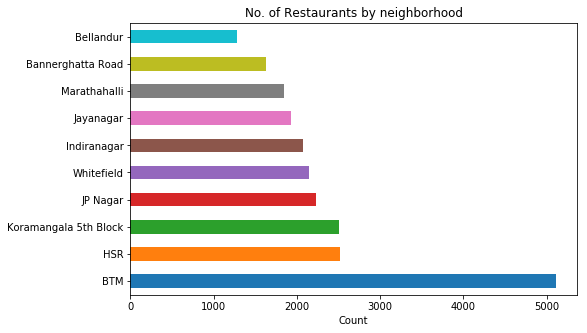

In [150]:
plt.figure(figsize=(8,5))
df['neighborhood'].value_counts().nlargest(10).plot(kind = "barh")
plt.title("No. of Restaurants by neighborhood")
plt.xlabel("Count")
plt.show()

#### Let's find which type of restaurants are most common

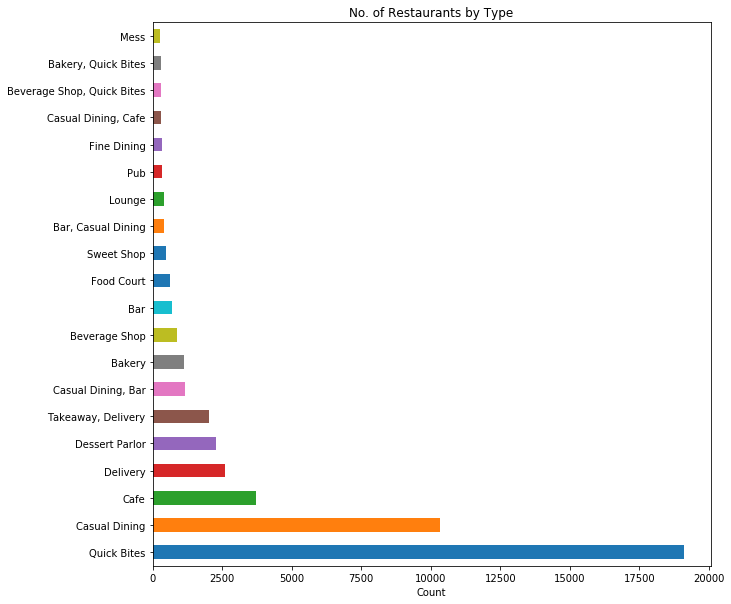

In [151]:
plt.figure(figsize=(10,10))
df['rest_type'].value_counts().nlargest(20).plot(kind = "barh")
plt.title("No. of Restaurants by Type")
plt.xlabel("Count")
plt.show()

#### Let's find which cuisines are most loved

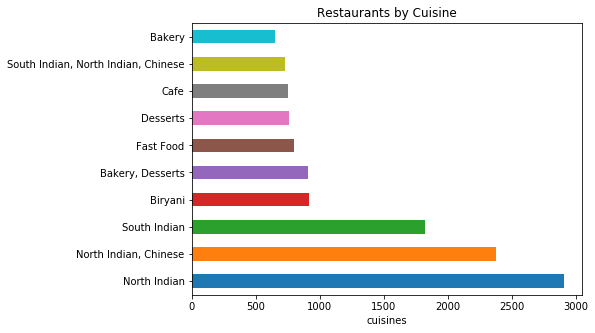

In [152]:
plt.figure(figsize=(7,5))
df['cuisines'].value_counts().nlargest(10).plot(kind = "barh")
plt.title("Restaurants by Cuisine")
plt.xlabel("cuisines")
plt.show()

#### Let's find which dishes are most liked by the reviewers

In [153]:
dishes = {}
for i in df['dish_liked']:
    for j in str(i).split(', '):
        if j in dishes.keys():
            dishes[j] = dishes[j] + 1
        else:
            dishes[j] = 1
dishes.pop('nan')
pd.DataFrame.from_dict(dishes, orient='index', columns=['dish_liked_count']).sort_values(['dish_liked_count'], ascending=False)[:20]

,dish_liked_count
Pasta,3399
Burgers,3018
Cocktails,2816
Pizza,2726
Biryani,2088
Coffee,1994
Mocktails,1878
Sandwiches,1676
Paratha,1565
Noodles,1414


#### Let's see which are the biggest Restaurant Chain

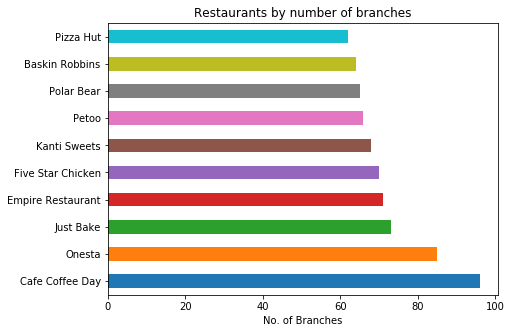

In [154]:
plt.figure(figsize=(7,5))
df['name'].value_counts().nlargest(10).plot(kind = "barh")
plt.title("Restaurants by number of branches")
plt.xlabel("No. of Branches")
plt.show()

#### Top dishes served in Bangalore

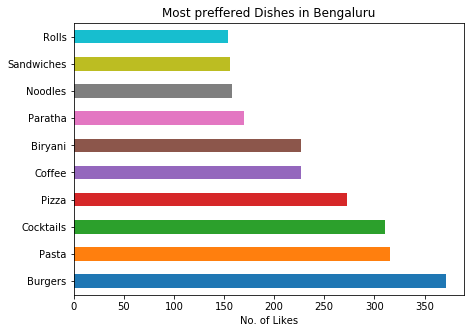

In [155]:
t1 = df.groupby(['dish_liked']).nunique().index.to_frame()
t2 = t1.dish_liked.str.strip().str.split(',', expand=True)
dish_liked=pd.concat([t2.iloc[:,0].str.strip(), t2.iloc[:,1].str.strip()]).value_counts()
dishes = dish_liked[:10]
plt.figure(figsize=(7,5))
dishes.plot.barh(x=dishes,y=dishes.index)
plt.title("Most preffered Dishes in Bengaluru")
plt.xlabel("No. of Likes")
plt.show()

### Lets get the coordinates for each of the neighborhood

In [156]:
neighborhood = [x for x in df['neighborhood'].unique().tolist() if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(neighborhood)):
    if(type(neighborhood[i]) == str):
        ctr=0
        while True:
            try:
                address = neighborhood[i] + ', Bengaluru, India'
                geolocator = Nominatim(user_agent="blr_explorer")
                loc = geolocator.geocode(address)
                latitude.append(loc.latitude)
                longitude.append(loc.longitude)
                print(loc.latitude, loc.longitude)
            except:
                ctr+=1
                if(ctr==7):
                    print(i)
                    latitude.append(address)
                    longitude.append(address)
                    break
                continue
            break

12.9152208 77.573598
12.9417261 77.5755021
12.9455407 77.5286919
12.9292731 77.5824229
12.9081487 77.5553179
12.9274413 77.5155224
12.96601575 77.61252417144667
12.9055682 77.5455438
12.9072515 77.5782713
13.0646907 77.49626895712257
12.965717999999999 77.5762705372058
12.9546741 77.5121724
12.8264929 77.5864733
12.911275849999999 77.60456543431182
12.8743272 77.5413886
12.9089453 77.6239038
17.2510682 80.1651978
12.9791198 77.5912997
12.91445305 77.64269383637028
12.9552572 77.6984163
12.9242381 77.6289059
12.9489339 77.5968273
12.9575547 77.5979099
12.9340114 77.6222304
12.9417812 77.6160146
12.970097 77.617066
12.9340114 77.6222304
13.0464531 77.5483803
12.93433385 77.63040639553275
12.9791198 77.5912997
12.9963995 77.7614229
12.9791198 77.5912997
12.9606699 77.6422283
12.9732913 77.6404672
34
12.996845 77.6130165
13.0227204 77.595715
12.9777384 77.6019226
12.9750605 77.6080323
12.9750062 77.5998217
12.9750521 77.6046959
12.9778793 77.6246697
13.0535126 77.6231566
12.986391 77.60754

### Let's get the number of restaurants in each neighborhood

In [157]:
df['lati'] = df['neighborhood'].map(dict(zip(neighborhood, latitude)))
df['longi'] = df['neighborhood'].map(dict(zip(neighborhood, longitude)))
df1 = df.groupby(['neighborhood'])['lati', 'longi'].first()
df1['no_restaurant'] = df.groupby(['neighborhood'])['name'].count()
df1
df2=df1.convert_objects(convert_numeric=True)
df2=df1.convert_objects(convert_numeric=True).dropna()
df2

C:\Users\ROBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\ROBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


,lati,longi,no_restaurant
neighborhood,,,
BTM,12.911276,77.604565,5109
Banashankari,12.915221,77.573598,904
Banaswadi,13.014162,77.651854,659
Bannerghatta Road,12.826493,77.586473,1628
Basavanagudi,12.941726,77.575502,684
Basaveshwara Nagar,12.993224,77.539158,191
Bellandur,12.979120,77.591300,1283
Bommanahalli,12.908945,77.623904,238
Brigade Road,12.975060,77.608032,1215


In [158]:
address = 'Bengaluru, India'
geolocator = Nominatim(user_agent="blr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bengaluru are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bengaluru are 12.9791198, 77.5912997.


In [159]:
df2.info

<bound method DataFrame.info of                                     lati      longi  no_restaurant
neighborhood                                                      
BTM                            12.911276  77.604565           5109
Banashankari                   12.915221  77.573598            904
Banaswadi                      13.014162  77.651854            659
Bannerghatta Road              12.826493  77.586473           1628
Basavanagudi                   12.941726  77.575502            684
Basaveshwara Nagar             12.993224  77.539158            191
Bellandur                      12.979120  77.591300           1283
Bommanahalli                   12.908945  77.623904            238
Brigade Road                   12.975060  77.608032           1215
Brookefield                    12.966821  77.716889            658
CV Raman Nagar                 17.251068  80.165198             89
Central Bangalore              12.979120  77.591300              8
Church Street                 

In [160]:
# create map of Bengaluru using latitude and longitude values
blr_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df2['lati'], df2['longi'], df2.index):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bengaluru)  
    
blr_map

#### Exploring the neighborhoods using the Foursquare API data

In [161]:
# Define Foursquare Credentials and Version
LIMIT = 100

CLIENT_ID = '5LJIZQISPWRP4Q5H5QGZB5BM410UVH0RCPPGYWJD3KQXMQF1' # your Foursquare ID
CLIENT_SECRET = 'EGIMPUJ3N0HAPGNZ4UOF2N3MN1TP4L3T2TK0JM0UNHIIFV1C' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5LJIZQISPWRP4Q5H5QGZB5BM410UVH0RCPPGYWJD3KQXMQF1
CLIENT_SECRET:EGIMPUJ3N0HAPGNZ4UOF2N3MN1TP4L3T2TK0JM0UNHIIFV1C


In [163]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Getting nearby venues

In [167]:
blr_venues = getNearbyVenues(names=df2.index,
                                   latitudes=df2['lati'],
                                   longitudes=df2['longi'],
                                  )

BTM
Banashankari
Banaswadi
Bannerghatta Road
Basavanagudi
Basaveshwara Nagar
Bellandur
Bommanahalli
Brigade Road
Brookefield
CV Raman Nagar
Central Bangalore
Church Street
City Market
Commercial Street
Cunningham Road
Domlur
East Bangalore
Ejipura
Electronic City
Frazer Town
HBR Layout
HSR
Hebbal
Hennur
Hosur Road
ITPL Main Road, Whitefield
Indiranagar
Infantry Road
JP Nagar
Jakkur
Jalahalli
Jayanagar
Jeevan Bhima Nagar
KR Puram
Kaggadasapura
Kalyan Nagar
Kammanahalli
Kanakapura Road
Kengeri
Koramangala
Koramangala 2nd Block
Koramangala 3rd Block
Koramangala 4th Block
Koramangala 5th Block
Koramangala 6th Block
Koramangala 7th Block
Koramangala 8th Block
Kumaraswamy Layout
Langford Town
Lavelle Road
MG Road
Magadi Road
Majestic
Malleshwaram
Marathahalli
Mysore Road
Nagarbhavi
Nagawara
New BEL Road
North Bangalore
Old Airport Road
Old Madras Road
Peenya
RT Nagar
Race Course Road
Rajajinagar
Rajarajeshwari Nagar
Residency Road
Richmond Road
Sadashiv Nagar
Sahakara Nagar
Sanjay Nagar
Sarj

In [279]:
print(blr_venues.shape)
blr_venues.head(15)

(1623, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BTM,12.911276,77.604565,Ginger Tea House,12.912498,77.606373,Bakery
1,BTM,12.911276,77.604565,Ashirwad Departmental Store,12.915237,77.606057,Department Store
2,BTM,12.911276,77.604565,Cafe Coffee Day,12.912062,77.606156,Café
3,BTM,12.911276,77.604565,Flavours of China,12.913776,77.607662,Chinese Restaurant
4,BTM,12.911276,77.604565,Baskin-Robbins,12.913697,77.607022,Ice Cream Shop
5,BTM,12.911276,77.604565,Disney Bakery,12.913697,77.607225,Bakery
6,BTM,12.911276,77.604565,Balaji's Veg,12.913810,77.608180,Vegetarian / Vegan Restaurant
7,BTM,12.911276,77.604565,Nandi Chat House,12.913762,77.607803,Snack Place
8,BTM,12.911276,77.604565,Faaso's,12.913709,77.607115,Fast Food Restaurant
9,BTM,12.911276,77.604565,Leo's Paratha Rolls,12.913787,77.607815,Snack Place


#### Venue data is grouped by count and category

In [169]:
blr_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
BTM,14,14,14,14,14,14
Banashankari,4,4,4,4,4,4
Banaswadi,8,8,8,8,8,8
Basavanagudi,11,11,11,11,11,11
Basaveshwara Nagar,19,19,19,19,19,19
Bellandur,4,4,4,4,4,4
Bommanahalli,4,4,4,4,4,4
Brigade Road,93,93,93,93,93,93
Brookefield,13,13,13,13,13,13


#### Let's see out how many venue categories can be found 

In [268]:
print('There are {} unique venue categories.'.format(len(blr_venues['Venue Category'].unique())))

There are 177 unique venue categories.


#### One hot encoding for analysisng the venues

In [171]:
blr_onehot = pd.get_dummies(blr_venues[['Venue Category']], prefix="", prefix_sep="")
blr_onehot['Neighborhood'] = blr_venues['Neighborhood'] 
fixed_columns = [blr_onehot.columns[-1]] + list(blr_onehot.columns[:-1])
blr_onehot = blr_onehot[fixed_columns]
blr_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio
0,BTM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BTM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BTM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BTM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BTM,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
blr_grouped = blr_onehot.groupby('Neighborhood').mean().reset_index()
blr_grouped

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio
0,BTM,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.071429,0.0,0.000000,0.00,0.000000,0.000000
1,Banashankari,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2,Banaswadi,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.250000,0.0,0.000000,0.00,0.000000,0.000000
3,Basavanagudi,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
4,Basaveshwara Nagar,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
5,Bellandur,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
6,Bommanahalli,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
7,Brigade Road,0.0,0.0,0.000000,0.010753,0.010753,0.000000,0.010753,0.000000,0.010753,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
8,Brookefield,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
9,CV Raman Nagar,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.000000


### Let's get the most common venue details in each neighborhood to perform clustering analysis

In [173]:
num_top_venues = 5
for hood in blr_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = blr_grouped[blr_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BTM----
               venue  freq
0             Bakery  0.14
1        Snack Place  0.14
2        Coffee Shop  0.07
3  Indian Restaurant  0.07
4         Food Truck  0.07


----Banashankari----
                  venue  freq
0  Gym / Fitness Center  0.25
1     Indian Restaurant  0.25
2         Metro Station  0.25
3          Liquor Store  0.25
4  Pakistani Restaurant  0.00


----Banaswadi----
                           venue  freq
0              Indian Restaurant  0.25
1  Vegetarian / Vegan Restaurant  0.25
2                      BBQ Joint  0.12
3                      Juice Bar  0.12
4              Convenience Store  0.12


----Basavanagudi----
                venue  freq
0   Indian Restaurant  0.36
1         Snack Place  0.09
2                Café  0.09
3          Hookah Bar  0.09
4  Athletics & Sports  0.09


----Basaveshwara Nagar----
                  venue  freq
0  Fast Food Restaurant  0.16
1        Ice Cream Shop  0.16
2                  Café  0.11
3           Pizza Place  0.11

                venue  freq
0   Indian Restaurant  0.17
1                Café  0.11
2         Coffee Shop  0.06
3  Italian Restaurant  0.04
4                 Pub  0.04


----Koramangala 8th Block----
               venue  freq
0  Indian Restaurant   0.6
1     Ice Cream Shop   0.2
2             Market   0.2
3                ATM   0.0
4    Paintball Field   0.0


----Kumaraswamy Layout----
               venue  freq
0      Movie Theater   0.2
1     Sandwich Place   0.2
2  Indian Restaurant   0.2
3               Pool   0.2
4             Bakery   0.2


----Langford Town----
                  venue  freq
0     Indian Restaurant  0.33
1             Juice Bar  0.33
2                 Hotel  0.33
3                   ATM  0.00
4  Pakistani Restaurant  0.00


----Lavelle Road----
               venue  freq
0  Indian Restaurant  0.11
1     Ice Cream Shop  0.11
2                Pub  0.07
3        Art Gallery  0.07
4     Breakfast Spot  0.07


----MG Road----
               venue  freq
0  Indian Res

4    Bus Station   0.2


----Wilson Garden----
                             venue  freq
0  Southern / Soul Food Restaurant  0.11
1                Indian Restaurant  0.11
2                             Café  0.11
3                            Hotel  0.11
4                      Coffee Shop  0.11


----Yelahanka----
               venue  freq
0                ATM   0.2
1  Mobile Phone Shop   0.2
2         Smoke Shop   0.2
3       Burger Joint   0.2
4      Train Station   0.2


----Yeshwantpur----
                  venue  freq
0         Train Station  0.16
1     Indian Restaurant  0.11
2  Fast Food Restaurant  0.11
3         Movie Theater  0.05
4                 Hotel  0.05




In [175]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [176]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = blr_grouped['Neighborhood']
for ind in np.arange(blr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blr_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,Bakery,Snack Place,Indian Restaurant,Department Store,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Café,Fast Food Restaurant,Shopping Mall
1,Banashankari,Indian Restaurant,Metro Station,Gym / Fitness Center,Liquor Store,Fast Food Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish Market
2,Banaswadi,Indian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Kerala Restaurant,BBQ Joint,Convenience Store,Andhra Restaurant,Financial or Legal Service,French Restaurant,Food Truck
3,Basavanagudi,Indian Restaurant,Café,Snack Place,Hookah Bar,Mediterranean Restaurant,Athletics & Sports,Restaurant,Tea Room,Yoga Studio,Food
4,Basaveshwara Nagar,Fast Food Restaurant,Ice Cream Shop,Café,Pizza Place,Liquor Store,Bakery,Sporting Goods Shop,Bus Station,Gym,Clothing Store


## K- Means clustering on Venue Data

Let's find the best K value to perform K-means analysis. Let us start with a initial K of 4 and calculating the best K which reduces the error and avoid overfitting by iterating till 30 K values

In [215]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=30, random_state=8)
X = blr_grouped.drop(['Neighborhood'], axis=1)
X.head()

,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [216]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 2, 2, 0, 1, 0, 0, 0, 0])

In [217]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=30, random_state=8)
    km.fit(X)
    return km.inertia_

In [218]:
scores = [get_inertia(x) for x in range(2, 32)]

Text(0, 0.5, 'Error')

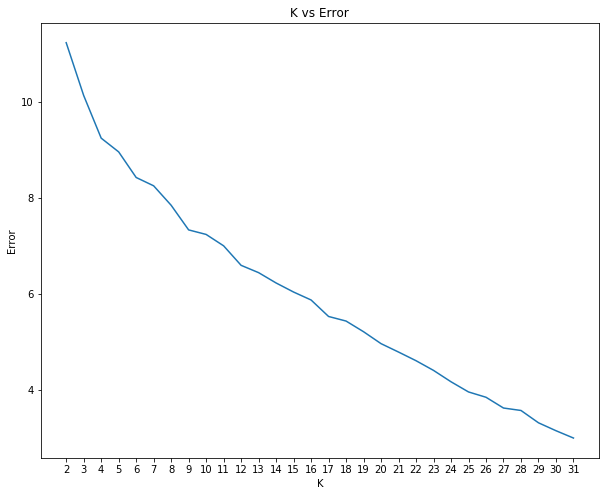

In [270]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 32), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 32))
plt.xlabel("K")
plt.ylabel("Error")

#### We have derived k=8 as a suitable value because steep slope in error values decreases noticeably after 8 and continues decreaing 

In [220]:
# set number of clusters as 8
kclusters = 8
blr_grouped_clustering = blr_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blr_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 0, 0, 0, 7, 1, 0, 7, 7, 7])

In [230]:
df2.reset_index(inplace = True) 
neighborhoods_venues_sorted.reset_index(inplace = True) 
df2.rename(columns={'neighborhood': 'Neighborhood'}, inplace=True)

In [242]:
blr_merged = df2
blr_merged = blr_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
blr_merged.head() 

,Neighborhood,lati,longi,no_restaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,12.911276,77.604565,5109,7.0,Bakery,Snack Place,Indian Restaurant,Department Store,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Café,Fast Food Restaurant,Shopping Mall
1,Banashankari,12.915221,77.573598,904,0.0,Indian Restaurant,Metro Station,Gym / Fitness Center,Liquor Store,Fast Food Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish Market
2,Banaswadi,13.014162,77.651854,659,0.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Kerala Restaurant,BBQ Joint,Convenience Store,Andhra Restaurant,Financial or Legal Service,French Restaurant,Food Truck
3,Bannerghatta Road,12.826493,77.586473,1628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Basavanagudi,12.941726,77.575502,684,0.0,Indian Restaurant,Café,Snack Place,Hookah Bar,Mediterranean Restaurant,Athletics & Sports,Restaurant,Tea Room,Yoga Studio,Food


In [250]:
blr_merged.drop(['level_0'],axis=1, inplace=True)
#neighborhoods_venues_sorted.drop(['index'],axis=1, inplace=True)
blr_merged

,Neighborhood,lati,longi,no_restaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,12.911276,77.604565,5109,7.0,Bakery,Snack Place,Indian Restaurant,Department Store,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Café,Fast Food Restaurant,Shopping Mall
1,Banashankari,12.915221,77.573598,904,0.0,Indian Restaurant,Metro Station,Gym / Fitness Center,Liquor Store,Fast Food Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish Market
2,Banaswadi,13.014162,77.651854,659,0.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Kerala Restaurant,BBQ Joint,Convenience Store,Andhra Restaurant,Financial or Legal Service,French Restaurant,Food Truck
3,Bannerghatta Road,12.826493,77.586473,1628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Basavanagudi,12.941726,77.575502,684,0.0,Indian Restaurant,Café,Snack Place,Hookah Bar,Mediterranean Restaurant,Athletics & Sports,Restaurant,Tea Room,Yoga Studio,Food
5,Basaveshwara Nagar,12.993224,77.539158,191,7.0,Fast Food Restaurant,Ice Cream Shop,Café,Pizza Place,Liquor Store,Bakery,Sporting Goods Shop,Bus Station,Gym,Clothing Store
6,Bellandur,12.979120,77.591300,1283,1.0,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
7,Bommanahalli,12.908945,77.623904,238,0.0,Indian Restaurant,Restaurant,Lake,Auto Garage,Department Store,Dessert Shop,Food Court,Food & Drink Shop,Food,Flea Market
8,Brigade Road,12.975060,77.608032,1215,7.0,Indian Restaurant,Café,Pub,Chinese Restaurant,Lounge,Bar,Coffee Shop,Hotel,Bookstore,Fast Food Restaurant
9,Brookefield,12.966821,77.716889,658,7.0,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Breakfast Spot,Department Store,Dessert Shop,Asian Restaurant,Salon / Barbershop,Gym,Multiplex


### Plotting the venues with clusters labelled

In [248]:

import math
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blr_merged['lati'], blr_merged['longi'], blr_merged['Neighborhood'], blr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[2],
        fill_opacity=0.7).add_to(map_clusters)   
map_clusters



## Analysing the 8 Clusters by most common venue details

### First Cluster 

In [263]:
blr_merged.loc[blr_merged['Cluster Labels'] == 0, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Banashankari,Indian Restaurant,Metro Station,Gym / Fitness Center,Liquor Store,Fast Food Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish Market
2,Banaswadi,Indian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Kerala Restaurant,BBQ Joint,Convenience Store,Andhra Restaurant,Financial or Legal Service,French Restaurant,Food Truck
4,Basavanagudi,Indian Restaurant,Café,Snack Place,Hookah Bar,Mediterranean Restaurant,Athletics & Sports,Restaurant,Tea Room,Yoga Studio,Food
7,Bommanahalli,Indian Restaurant,Restaurant,Lake,Auto Garage,Department Store,Dessert Shop,Food Court,Food & Drink Shop,Food,Flea Market
13,City Market,Indian Restaurant,Plaza,Diner,Middle Eastern Restaurant,Food Truck,South Indian Restaurant,Bookstore,Market,Miscellaneous Shop,Historic Site
14,Commercial Street,Indian Restaurant,Clothing Store,Hotel,Women's Store,Juice Bar,Bar,Donut Shop,Fast Food Restaurant,Candy Store,Burger Joint
15,Cunningham Road,Indian Restaurant,Coffee Shop,Chinese Restaurant,Hotel,Café,Pizza Place,Italian Restaurant,Hookah Bar,Middle Eastern Restaurant,Mediterranean Restaurant
16,Domlur,Indian Restaurant,Café,Smoke Shop,Chinese Restaurant,Food & Drink Shop,Restaurant,Lounge,Liquor Store,Rajasthani Restaurant,Sports Bar
18,Ejipura,Indian Restaurant,Department Store,Fish & Chips Shop,General Entertainment,Chinese Restaurant,Gym / Fitness Center,Nightclub,Farmers Market,Food,Flea Market
20,Frazer Town,Indian Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Chinese Restaurant,Tea Room,BBQ Joint,Snack Place,Pizza Place,Gym,Fast Food Restaurant


### Second Cluster 

In [264]:
blr_merged.loc[blr_merged['Cluster Labels'] == 1, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bellandur,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
11,Central Bangalore,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
17,East Bangalore,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
19,Electronic City,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
60,North Bangalore,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
85,West Bangalore,Restaurant,Park,Capitol Building,Yoga Studio,Electronics Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service


### Third Cluster 

In [265]:
blr_merged.loc[blr_merged['Cluster Labels'] == 2, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Koramangala 3rd Block,Indian Restaurant,Hotel Bar,Hotel,Breakfast Spot,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop
49,Langford Town,Indian Restaurant,Hotel,Juice Bar,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
65,Race Course Road,Indian Restaurant,Hotel,Planetarium,Juice Bar,Coffee Shop,Racetrack,Hotel Bar,Vietnamese Restaurant,Cricket Ground,Eastern European Restaurant
80,Ulsoor,Indian Restaurant,Light Rail Station,Hotel,Café,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
83,Vasanth Nagar,Indian Restaurant,Hotel,Nightclub,Golf Course,Coffee Shop,Art Gallery,Restaurant,Lounge,Art Museum,Hotel Bar


### Fourth Cluster 

In [266]:
blr_merged.loc[blr_merged['Cluster Labels'] == 3, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
82,"Varthur Main Road, Whitefield",Indian Restaurant,Candy Store,Cricket Ground,Cupcake Shop,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service


### Fifth Cluster 

In [256]:
blr_merged.loc[blr_merged['Cluster Labels'] == 4, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Old Madras Road,Café,Restaurant,Yoga Studio,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Fast Food Restaurant


### Sixth Cluster 

In [257]:
blr_merged.loc[blr_merged['Cluster Labels'] == 5, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,Nagarbhavi,Gym,Food Truck,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Fast Food Restaurant,Farmers Market


### Seventh Cluster 

In [258]:
blr_merged.loc[blr_merged['Cluster Labels'] == 6, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Jeevan Bhima Nagar,Indian Restaurant,Café,Department Store,Chinese Restaurant,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
47,Koramangala 8th Block,Indian Restaurant,Ice Cream Shop,Market,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
52,Magadi Road,Indian Restaurant,Resort,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Fast Food Restaurant
53,Majestic,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Bus Station,Metro Station,Platform,Hotel,Hookah Bar,Electronics Store,Flea Market
76,Shivajinagar,Indian Restaurant,Fast Food Restaurant,Shoe Store,South Indian Restaurant,Clothing Store,Furniture / Home Store,Juice Bar,Donut Shop,Market,Tea Room


### Eigth Cluster 

In [278]:
blr_merged.loc[blr_merged['Cluster Labels'] == 7, blr_merged.columns[[0] + list(range(5, blr_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BTM,Bakery,Snack Place,Indian Restaurant,Department Store,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Café,Fast Food Restaurant,Shopping Mall
5,Basaveshwara Nagar,Fast Food Restaurant,Ice Cream Shop,Café,Pizza Place,Liquor Store,Bakery,Sporting Goods Shop,Bus Station,Gym,Clothing Store
8,Brigade Road,Indian Restaurant,Café,Pub,Chinese Restaurant,Lounge,Bar,Coffee Shop,Hotel,Bookstore,Fast Food Restaurant
9,Brookefield,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Breakfast Spot,Department Store,Dessert Shop,Asian Restaurant,Salon / Barbershop,Gym,Multiplex
10,CV Raman Nagar,Fried Chicken Joint,Electronics Store,Health & Beauty Service,Breakfast Spot,Department Store,Financial or Legal Service,Cupcake Shop,Food Court,Food & Drink Shop,Food
12,Church Street,Indian Restaurant,Café,Coffee Shop,Lounge,Pub,Bookstore,Music Store,Plaza,Clothing Store,Steakhouse
21,HBR Layout,Café,Road,South Indian Restaurant,Coffee Shop,North Indian Restaurant,Food,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service
27,Indiranagar,Pub,Lounge,Cocktail Bar,Indian Restaurant,Café,Restaurant,Bakery,Italian Restaurant,Cupcake Shop,Ice Cream Shop
29,JP Nagar,Department Store,Indian Restaurant,Pub,Boarding House,Bus Station,Chinese Restaurant,Brewery,Fast Food Restaurant,Bakery,Yoga Studio
36,Kalyan Nagar,Indian Restaurant,BBQ Joint,Ice Cream Shop,Korean Restaurant,Fast Food Restaurant,Coffee Shop,Café,Italian Restaurant,Electronics Store,Clothing Store



## Conclusion

We have made an analysis of bengaluru restaurant data according to its neighborhoods and also found out the characteristics of different neighborhoods by getting their most common venue details. we have plotted them in charts and map. We have also segmented the neighborhoods into eight clusters and analysed them. Some interesting findings from the data are:

* BTM is the neighborhood that have most number of restaurants.
* Quick bites and casual dining are more popular types of restaurants in B'lore.
* North Indian cuisine is the most preferred cuisine of the city.
* Cafe coffee day is the largest restaurant chain by number of branches followed by Onesta.
* Top three among the most liked dishes/drinks are Burger,Pasta and Cocktails.
* We have segemented the neighborhoods into eight clusters using k-means technique.
* First cluster and eighth cluster are bigger ones with more number of neighborhoods while remaining are smaller ones.
* First, third and seventh cluster have a large number of retaurants and have them as most common venues.